# CS 224, Fall 2021
## Problem Set 2

## **DUE SUNDAY, November 14, 2021 @ 11:59pm PDT **

<div class="alert alert-info">
    <b>Complete with your Information</b><br>
    <i>By Submitting this notebook, I assert that all of the work presented here is my own and performed for the express sole purpose of this offering of this course.</i><br>
        <br>
      <b>(full) Name:</b>  Bipin Dhoddamane Ravi  <br>
    <b>Student ID Number:</b> 862315841
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: /15<br>
    Late Days Used on this Assignment: <br>
    Total Late Days Used: <br>
</div>

## Preliminaries

We will again be using the data shown in class on house sales in Ames, Iowa.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The code block below again loads in the data.  However, this time we will be using a one-hot encoding of the categorical features (see code comments). 

**Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

The resulting variables are slightly different than last time:
 - `trainX` & `trainY`: the training data, `trainX` has shape (number of homes, number of features) and `trainY` has shape (number of homes,).  We are trying to predict the y-values (home prices) from the x-values (other features of the homes for sale).
 - `testX` & `testY`: the testing data, in the same format at the training data.  We will use this as independent testing samples to see how well the training worked.
 - `bintrainY` & `bintestY`: training and testing Y values, but as binary values (0 or 1) indicating whether the home price is above $200K (used in the second part)
 - `featurenames`: an array (of strings) of each of the features'/columns' names
 - `nfeat`: total number of features/columns

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # this and above will make the figures large enough to read
def loadamesdata(trainfrac = 0.5):
    import pandas as pd
    from IPython.display import display
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])
    
    categoricalf = [col for col in dataframe if dataframe[col].dtype.name=='object' or col=='MS SubClass']
     # Here we are encoding the categorical variables using a "one-hot" encoding.  A variable with 3 values (A, B, C)
    # gets converted into three binary variables.  For any example (row) exactly one of these binary variables is 1
    # indicating which value the original categorical variable took on.
    dataframe = pd.get_dummies(dataframe,columns=categoricalf,prefix=categoricalf,dummy_na=True)
    # Here we are going to remove any item that is missing a value (encoded as NaN at this stage)
    # This is slightly problematic (it could be the missingness is actually related to the value or other features' values)
    # Filling it in (with say the average for that feature) is also problematic, in different ways
    # So for this problem set, we'll just remove listings (rows) that are missing any of their non-categorical features
    dataframe.dropna(inplace=True) # 
    
    dataframe = dataframe.loc[:,(dataframe!=dataframe.iloc[0]).any()] # drop features that have all the same value (across both training and testing)
    
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed
    dataframe = dataframe[[c for c in dataframe if c != 'SalePrice']+['SalePrice']]# rearrange to put SalePrice at the end:
    # training/testing split
    # can use "from sklearn.model_selection import train_test_split"
    # but to more directly show what is going on, here is a more "raw" version:
    allXY = dataframe.to_numpy()
    

    allXY = allXY[np.isfinite(allXY).all(axis=1),:]
    
    # in general, we would take a random shuffle.  However, to grade this consistently, I am going to fix the randomness of the shuffle
    np.random.seed(829281934) # my favorite number (well, out of the natural numbers) ;)
    np.random.shuffle(allXY) # randomly shuffles the *rows* of the input (or along whatever is the first dimension of the tensor)
    # we'll pick the first 50% (as default -- see "trainfrac" parameter as training and save the last 50% for testing
    lasttraini = int(allXY.shape[0]*trainfrac)
    trainXY = allXY[:lasttraini,:]
    testXY = allXY[lasttraini:,:]
    
    trainX = trainXY[:,:-1]
    trainY = trainXY[:,-1]
    testX = testXY[:,:-1]
    testY = testXY[:,-1]

    return trainX,trainY,testX,testY, dataframe.columns

trainX,trainY,testX,testY,featurenames = loadamesdata()
nfeat = trainX.shape[1]
binaryclassthreshold = 200
bintrainY = (trainY>binaryclassthreshold).astype(int)
bintestY = (testY>binaryclassthreshold).astype(int)

### Data Normalization

First, we are going to "standardize" or "normalize" each input feature.  Consider that the square footage for living area is not really 
comparable with the year built or the number of kitchens.  To put these different features "on the same scale," we will divide each by
its standard deviation.

There is no principled reason to expect this to have a useful effect.  However, in practice, this works very well as an initial normalizing
step and is fairly universal.

After you have completed the assignment, you may try commenting out the code below and rerunning to see the difference.  It is instructive.  However, please
submit with this code block active.

In [2]:
stddevs = np.std(trainX,axis=0)+1e-6
trainX /= stddevs
testX /= stddevs

## Problem set overview

This problem set considers the problem of predicting the sale price from all of the other features in two ways:
1. Using regression to predict the price
2. Using classification to predict whether the price is greater than 200 (i.e., $200K)

In the first part, we will use PCA to reduce the number of features.  PCA does not consider `Y`, but just looks at `X`.  We will use ridge regression (linear least squares with a L2 regularization penalty), varying the number of PCA components used.

In the second part, we will use LDA and logistic regression for binary classification.

In both cases, we will train on the training set and test on the testing set.  We will generate two side-by-side plots of the performance of the methods versus the regularization strength.  

<div class="alert alert-warning">
    <font size=+2>Question 1</font><br>
    <font size=+1>2 points</font>
</div>

<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /2<br>
</div>

Plot a scree plot (Section 20.1.4.2 in the book) for the `X` matrix of data.  We will *not* use this to pick the number of principal components, but it is useful to visualize.

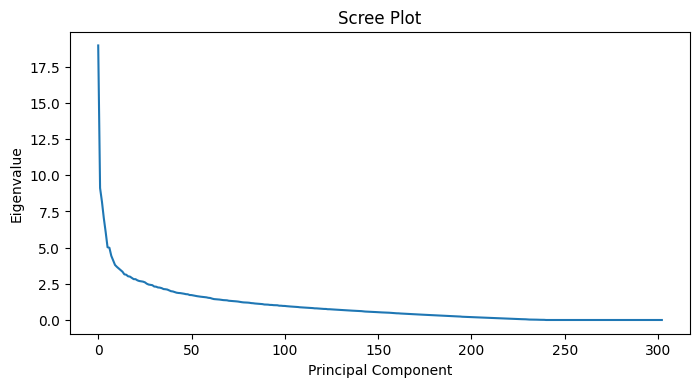

In [3]:
#Center the data
X = trainX - np.mean(trainX,axis=0)

#take SVD on the data
U,D,V = np.linalg.svd(X)

#sort the data
indorder = np.argsort(-D)
D = D[indorder]

#calculate eigen values
eigen_values=(D**2)/X.shape[0]

plt.plot(eigen_values)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue') 
plt.show()

<div class="alert alert-warning">
    <font size=+2>Question 2</font><br>
    <font size=+1>4 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /4<br>
</div>

Write code to perform PCA, selecting `k` components.  I would recommend a function that takes in X and k.  It should return the transformed version of X (plus information to perform the same transform on other data... see below)

Write code to perform ridge regression.  I would recommend a function that takes in X, Y, and the regularization strength.  It should return the resulting weight vector.

Create two side-by-side plots of the mean squared prediction error versus the regularization strength.  The left plot should be for the training set.  The right plot should be for the testing set.  Plot 4 lines in each: using 50 principal components, using 100 principal components, using 200 principal components, and without PCA (just the raw `X` as provided).

Further directions and reminders:
- Your plots should should have the "x-axis" (the regularization strength) on a log-scale.  Use `semilogx` instead of `plot` in matplotlib.
- Be sure to label your plots (title), axes, and provide a legend.
- Use values for the regularization strength from $10^{-1}$ to $10^{3}$, arranged evenly on a log scale.  (See numpy's `logspace` function.)  I would recommend 20-30 points for a nice smooth curve.
- When performing PCA, the projection axes (principal components) are determined from the training data.  They are applied to both the
  training and testing data.  That is, do not separately calculate a PCA for the testing data; that would result in axes that could be
  different from those used for training and render the learned weights useless.
- Remember to add an offset term (probably by adding an extra column of 1s -- but remember this extra column of 1s is not part of the 
  data for PCA)
- Do not penalize the offset term in the regularization.  This can be done by using the formula
\begin{align*}
    w_\text{ridge} &= (X^T X + \lambda\tilde{I})^{-1}X^T Y
\end{align*}
  which is the same as demonstrated in class, except that $\tilde{I}$ is not *quite* the identity matrix.  It is an identity
  matrix, but where the diagonal element corresponding the to offset term has been set to $0$ (instead of $1$).



In [5]:
def pca(X,k): # a suggestion only
    #center the data
    X_meaned = X - np.mean(X , axis = 0)

    #calculate covariance matrix
    cov_mat = np.cov(X_meaned , rowvar = False)
    #get eigen vectors and values
    eigen_values , eigen_vectors = np.linalg.eig(cov_mat)
    #sort them
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    #select the first highest given k componenets
    eigenvector_subset = sorted_eigenvectors[:,0:k]
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
    return X_reduced, eigenvector_subset

#mean squared prediction error
def mse(y_hat,y):
    return  np.square(np.subtract(y,y_hat)).mean()

#ridge regression
def ridge(X,Y,rlambda,):
    XT = np.transpose(X)
    I = np.eye(X.shape[1],X.shape[1])
    I[-1,-1] = 0

    XTX = np.matmul(XT, X) + rlambda * I
    W = np.matmul(np.matmul(np.linalg.inv(XTX), XT), Y)
    return W

C:\Users\EndUser\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\EndUser\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\EndUser\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\EndUser\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\EndUser\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting comple

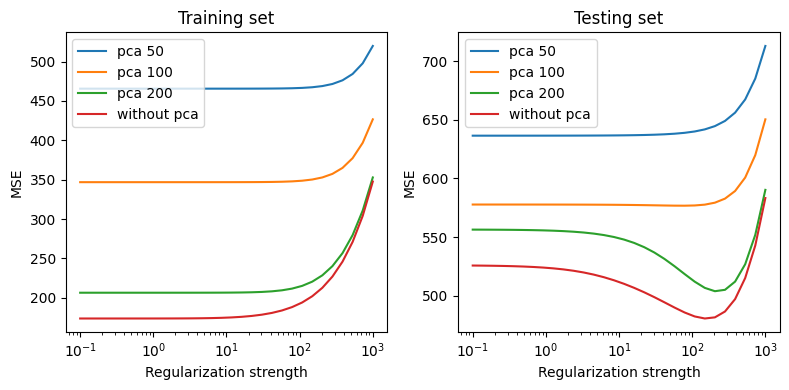

In [6]:
fig,axs = plt.subplots(1,2)

#set regularization strenght
reg_strenght = np.logspace(start=-1,stop=3.0,num=30)

#pca values 
pca_vals = [50,100,200]

#loop through pca values
for k in pca_vals:
    #get the transformd data and the eign vectors
    x_pca_train,eigenvector_subset = pca(trainX,k)

    #add offset to data
    x_pca_train = np.hstack((x_pca_train,np.ones((len(x_pca_train),1))))

    #center the testing data based on training mean
    x_test_meaned = testX - np.mean(trainX , axis = 0)
    x_pca_test = np.dot(eigenvector_subset.transpose() , x_test_meaned.transpose() ).transpose()
    x_pca_test = np.hstack((x_pca_test,np.ones((len(x_pca_test),1))))

    #lists used to store the computed mse values
    mse_vals_train = []
    mse_vals_test = []

    #loop through lambda values
    for rlambda in reg_strenght:
        W = ridge(x_pca_train,trainY,rlambda)
        y_hat_train = x_pca_train@W
        mse_vals_train.append(mse(y_hat_train,trainY))
        
        y_hat_test = x_pca_test@W
        # print(y_hat_test[:3])
        # print(testY[:3])
        mse_vals_test.append(mse(y_hat_test,testY))
    # print(mse_vals_test)

    axs[0].semilogx(reg_strenght,mse_vals_train,label='pca '+ str(k))
    axs[1].semilogx(reg_strenght,mse_vals_test,label='pca '+ str(k))

#without pca
mse_vals_train = []
mse_vals_test = []

x_non_pca_train = np.hstack((trainX,np.ones((len(trainX),1))))
x_non_pca_test = np.hstack((testX,np.ones((len(testX),1))))

for rlambda in reg_strenght:
    W = ridge(x_non_pca_train,trainY,rlambda)
    y_hat_train = x_non_pca_train@W
    mse_val = mse(y_hat_train,trainY)
    mse_vals_train.append(mse_val)
    
    y_hat_test = x_non_pca_test@W
    mse_val  = mse(y_hat_test,testY)
    mse_vals_test.append(mse_val)

#for plotting the lines
axs[0].semilogx(reg_strenght,mse_vals_train,label='without pca')
axs[1].semilogx(reg_strenght,mse_vals_test,label='without pca')

axs[0].legend() 
axs[1].legend() 

axs[0].set_title('Training set')
axs[0].set_xlabel('Regularization strength')
axs[0].set_ylabel('MSE')

axs[1].set_title('Testing set')
axs[1].set_xlabel('Regularization strength')
axs[1].set_ylabel('MSE')

plt.gcf().tight_layout()

<div class="alert alert-warning">
    <font size=+2>Question 3</font><br>
    <font size=+1>2 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /2<br>
</div>

What do the results above imply about using PCA on this dataset?

In [11]:
"""
By observing the graphs, we notice that, using PCA to reduce the dimensions increases the mean squared error.
The best performance is given by the raw X, and higher PCA value like PCA 200.
We also observe that using regularization on raw X and PCA 200 reduces overfitting and achieves the lowest
mean squared error just above regularization strength of 10^2 and below 10^3. The regularization strength does 
not have much effect on lower PCA like PCA 50 and PCA 100 until 10^2, so regularization does not have much effect on lower
PCA.
"""

'\nBy observing the graphs, we notice that, using PCA to reduce the dimensions increases the mean squared error.\nThe best performance is given by the raw X, and higher PCA value like PCA 200.\nWe also observe that using regularization on raw X and PCA 200 reduces overfitting and achieves the lowest\nmean squared error just above regularization strength of 10^2 and below 10^3. The regularization strength does \nnot have much effect on lower PCA like PCA 50 and PCA 100 until 10^2, so regularization does not have much effect on lower\nPCA.\n'

### Your Answer Here

<div class="alert alert-warning">
    <font size=+2>Question 4</font><br>
    <font size=+1>4 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /4<br>
</div>

For this question, we will be doing classification.  Therefore, we will use `bintrainY` and `bintestY`.

Below is code that performs logistic regression with regularization (by using the sklearn library -- for your code you may not use libraries other than numpy and matplotlib).  

Write a function that performs binary LDA, returning the weight vector for the decision boundary.  Note that your version of LDA needs to be able to accept regularization.  We haven't covered regularizing LDA in class.  You can achieve the same effect by putting a prior over the (shared) covariance matrix.  Distributions over matrices are beyond the scope of this course, so I'll just note that the resulting estimates for the priors and the means is the same, but the estimate for $\Sigma$ is
\begin{align*}
\hat{\Sigma} &= \frac{1}{m+\lambda}\left(\lambda I + \sum_{i=1}^m (x_i - \mu_{y_i})(x_i - \mu_{y_i})^T\right)
\end{align*}

Thus, we can use either logistic regression or LDA to predict whether the selling price will be greater than 200.  We could also use the ridge regression method from above.  We would train it on the regression values for Y, but test whether the resulting prediction was accurate in this binary sense (i.e., did it predict "greater than 200" correctly).

Create two side-by-side plots of the error rate (fraction of examples mis-predicted) versues the regularization strength.  The left plot should be for the training set.  The right plot should be for the testing set.  Plot 3 lines in each: LDA, logistic regression, and ridge regression, where the last is trained on continuous values but tested on this binary classification task.

Further directions and reminders:
- Do not use PCA for this part.
- Again, remember to include the intercept term.
- Again, your plots should be on semi-log axes.  Plot the regularization strength between $10^{-3}$ and $10^{4}$ for this problem.
- Be sure to label your plots, just as in question 2.

In [7]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))

def lr(X,Y,lam=0.0):
    from sklearn.linear_model import LogisticRegression
    C = 0.5/max(lam,1e-10)
    lr = LogisticRegression('l2',C=C,solver='liblinear').fit(X,Y)
    w = lr.coef_
    b = lr.intercept_
    return w,b # f(x) = x'*w + b

In [8]:
def lda(X,Y,lam): # a suggestion, but not required
    
    #plus is the first class and minus is the other class
    plusX, minusX = X[np.where(Y==1)], X[np.where(Y==0)]

    #calculate mean
    muplus, muminus = np.sum(plusX, axis=0)/plusX.shape[0], np.sum(minusX, axis=0)/minusX.shape[0]
    
    diffplus, diffminus = plusX - muplus, minusX - muminus
    diff = diffplus.T@diffplus + diffminus.T@diffminus

    #find covariance matrix
    cov = (diff+(lam * np.identity(X.shape[1])))/(X.shape[0] + lam)

    #find inverse of cavariance matrix
    invcov = np.linalg.inv(cov)

    w = invcov@(muplus-muminus).T

    #intercept term
    piplus, piminus = plusX.shape[0]/X.shape[0], minusX.shape[0]/X.shape[0]
    b = np.log(piplus/piminus) - 0.5*muplus@invcov@muplus.T + 0.5*muminus@invcov@muminus.T

    #add intercept term to w
    w = np.insert(w, 0, b)

    #return w including b
    return w


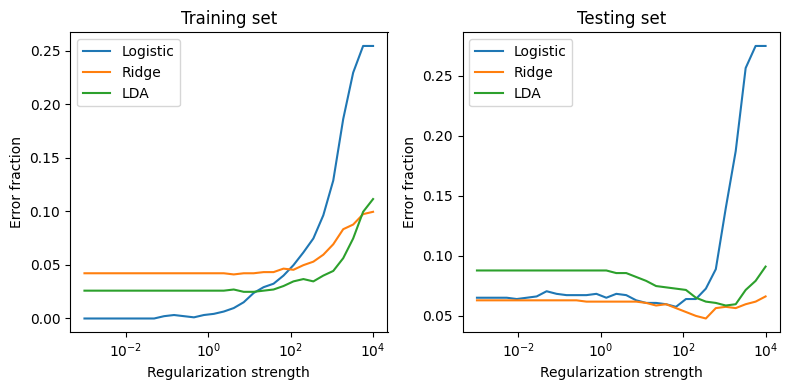

In [9]:
fig,axs = plt.subplots(1,2)
# plotting code here

#X for ridge regression without pca
x_non_pca_train = np.hstack((trainX,np.ones((len(trainX),1))))
x_non_pca_test = np.hstack((testX,np.ones((len(testX),1))))

#lists for each error for the different methods
lr_error_train = []
ridge_error_train = []
lda_error_train = []

lr_error_test = []
ridge_error_test = []
lda_error_test = []

def cal_error(y_hat,y):
    miscalculated  = 0 
    for i,j in zip(y_hat,y):
        if i != j:
            miscalculated+=1
    return miscalculated

reg_strenght = np.logspace(start=-3,stop=4.0,num=30)
for lam in reg_strenght:

    #Logistic regression
    w,b = lr(trainX,bintrainY, lam)
    y = sigmoid(np.dot(trainX,w.T) + b)
    predY = (y>0.5).astype(int)
    lr_error_train.append(cal_error(predY,bintrainY)/bintrainY.shape[0])

    y = sigmoid(np.dot(testX,w.T) + b)
    predY = (y>0.5).astype(int)
    lr_error_test.append(cal_error(predY,bintestY)/bintestY.shape[0])

    #Ridge Regression
    w = ridge(x_non_pca_train,trainY,lam)
    y_hat_train = x_non_pca_train@w
    y_hat_train = (y_hat_train>binaryclassthreshold).astype(int)
    ridge_error_train.append(cal_error(y_hat_train,bintrainY)/bintrainY.shape[0])

    y_hat_test = x_non_pca_test@w
    y_hat_test = (y_hat_test>binaryclassthreshold).astype(int)
    ridge_error_test.append(cal_error(y_hat_test,bintestY)/bintestY.shape[0])

    #LDA
    w = lda(trainX,bintrainY,lam)
    newX = np.hstack([np.ones((trainX.shape[0], 1)), trainX])
    predY = newX@w.T
    predY = (predY>0).astype(int)
    lda_error_train.append(cal_error(predY,bintrainY)/bintrainY.shape[0])

    newX = np.hstack([np.ones((testX.shape[0], 1)), testX])
    predY = newX@w.T
    predY = (predY>0).astype(int)
    lda_error_test.append(cal_error(predY,bintestY)/bintestY.shape[0])

#for plotting
axs[0].semilogx(reg_strenght,lr_error_train, label = 'Logistic')
axs[0].semilogx(reg_strenght,ridge_error_train, label = 'Ridge')
axs[0].semilogx(reg_strenght,lda_error_train, label = 'LDA')
axs[0].set_title('Training set')
axs[0].set_xlabel('Regularization strength')
axs[0].set_ylabel('Error fraction')
axs[0].legend() 

axs[1].semilogx(reg_strenght,lr_error_test, label = 'Logistic')
axs[1].semilogx(reg_strenght,ridge_error_test, label = 'Ridge')
axs[1].semilogx(reg_strenght,lda_error_test, label = 'LDA')
axs[1].legend() 
axs[1].set_title('Testing set')
axs[1].set_xlabel('Regularization strength')
axs[1].set_ylabel('Error fraction')

plt.gcf().tight_layout()

<div class="alert alert-warning">
    <font size=+2>Question 5</font><br>
    <font size=+1>3 points</font>
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

a. What can you conclude about selecting which method to use based on the training data?

b. What can you conclude about selecting the regularization strength based on the training data?

c. Ridge regression was not trained for classification, yet it does well (or better) than the method specifically trained for classification.  Why might that be?


### Your Answers Here

In [10]:
"""
a) Based only one the training set we see that Logistic Regression has the best performance with the lowest miscalculations
while in the testing set ridge regression has the best performance.

b) Based only training set we see that using the regularization strength of around 10^-2 gives the lowest miscalculations 
on logistic regression and the others. Using higher than 10^-1 starts to show worse performance of logistic regression

c) As the data we are working with is linearly separable, using Ridge on training data, 
will predict sales price as near to the true sales price as can be.
Then using a binary threshold will be able to correctly classify it into 
binary classes without the need for labels for data classification.
Errors in predicting sales price is ignored if it’s not near the threshold value.
Ridge regression is not as prone to overfitting as logistic regression.
"""


'\na) Based only one the training set we see that Logistic Regression has the best performance with the lowest miscalculations\nwhile in the testing set ridge regression has the best performance.\n\nb) Based only training set we see that using the regularization strength of around 10^-2 gives the lowest miscalculations \non logistic regression and the others. Using higher than 10^-1 starts to show worse performance of logistic regression\n\nc) As the data we are working with is linearly separable, using Ridge on training data, \nwill predict sales price as near to the true sales price as can be.\nThen using a binary threshold will be able to correctly classify it into \nbinary classes without the need for labels for data classification.\nErrors in predicting sales price is ignored if it’s not near the threshold value.\nRidge regression is not as prone to overfitting as logistic regression.\n'